# Multi-class Boosting on CGC Data

In [1]:
def load_cgc_metadata():
    import pandas as pd, os
    metadata = pd.DataFrame()

    for file in os.listdir(os.path.dirname(os.path.dirname(os.getcwd()))+"\\Data\\GeneExpression\\"):
        if "manifest" in file:
            if metadata.empty:
                metadata = pd.read_csv(os.path.dirname(os.path.dirname(os.getcwd()))+"\\Data\\GeneExpression\\" + file).loc[:, ["name", "disease_type", "id", 'vital_status']]
            else:
                data = pd.read_csv(os.path.dirname(os.path.dirname(os.getcwd()))+"\\Data\\GeneExpression\\" + file).loc[:, ["name", "disease_type", "id", 'vital_status']]
                metadata = pd.concat([metadata, data])

    metadata = metadata.reset_index(drop= True).drop_duplicates()

    return metadata

def load_cgc_data():
    import pandas as pd, os

    metadata = load_cgc_metadata()
    
    directory = os.path.dirname(os.path.dirname(os.getcwd())) + "\\Data\\GeneExpression\\Files\\"
    master = pd.DataFrame()

    for file in os.listdir(directory):
        tsv_file_path = directory + file

        df = pd.read_csv(tsv_file_path, sep='\t')
        df = pd.DataFrame(df.set_index("miRNA_ID")["reads_per_million_miRNA_mapped"]).rename(columns={"reads_per_million_miRNA_mapped":file}).T

        master = pd.concat([master,df])
    
    df = metadata.set_index("name").join(master).set_index("id")
        
    return df

In [2]:
df = load_cgc_data()

## Data Pre-processing

In [12]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
df["disease_type"].value_counts()

Myeloid Leukemias     594
Lymphoid Leukemias    223
Leukemias, NOS         34
Other Leukemias         1
Name: disease_type, dtype: int64

It seems that there is one observations that belongs to "Other Leukemias" which needs to be dropped. Almost all observations belong to the "Myeloid Leukemias" and "Lymphoid Leukemias" classes. 

In [14]:
df2 = df[df["disease_type"] != "Other Leukemias"]

In [15]:
def encode_multiclass(x):
    """
    Encode the input leukemia type into a numerical value.

    Parameters:
    - x (str): The input leukemia type.

    Returns:
    - int: The encoded numerical value.
      0: If x is "Myeloid Leukemias".
      1: If x is "Lymphoid Leukemias".
      2: For any other input.
    """
    if x == "Myeloid Leukemias":
        return 0
    elif x == "Lymphoid Leukemias":
        return 1
    else:
        return 2


In [16]:
# create X and y 
X = df2.drop(columns = ["disease_type", "vital_status"])
y = df2["disease_type"].apply(encode_multiclass)

In [17]:
# split into train, test, and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=4)
X_train2, X_test, y_train2, y_test = train_test_split(X_train, y_train, train_size=0.7, random_state=4)

## ADA Boosting
Inspiration taken from: https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_multiclass.html

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Define a weak learner using a decision tree with a maximum of 8 leaf nodes
weak_learner = DecisionTreeClassifier(max_leaf_nodes=8)

# Specify the number of weak learners (trees) in the ensemble
n_estimators = 300

# Create an AdaBoost classifier using the specified weak learner and parameters
# - estimator: The base model or weak learner (in this case, a decision tree).
# - n_estimators: The number of weak learners in the ensemble.
# - algorithm: The boosting algorithm. "SAMME" stands for Stagewise Additive Modeling using a Multiclass Exponential loss function.
# - random_state: Seed for reproducibility.
# Fit the AdaBoost classifier to the training data (X_train2, y_train2).
model1 = AdaBoostClassifier(
    estimator=weak_learner,
    n_estimators=n_estimators,
    algorithm="SAMME",
    random_state=42,
).fit(X_train2, y_train2)


In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create a DummyClassifier as a baseline model
dummy_clf = DummyClassifier()

# Define a function to calculate misclassification error
def misclassification_error(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

# Calculate misclassification error for DecisionTreeClassifier (weak learner)
weak_learners_misclassification_error = misclassification_error(
    y_test, weak_learner.fit(X_train2, y_train2).predict(X_test)
)

# Calculate misclassification error for DummyClassifier
dummy_classifiers_misclassification_error = misclassification_error(
    y_test, dummy_clf.fit(X_train2, y_train2).predict(X_test)
)

# Calculate misclassification error for the AdaBoost model (model1)
boosting_model_misclassification_error = misclassification_error(
    y_test, model1.predict(X_test)
)

# Display the results
print(
    "DecisionTreeClassifier's misclassification error: "
    f"{weak_learners_misclassification_error:.3f}"
)
print(
    "DummyClassifier's misclassification error: "
    f"{dummy_classifiers_misclassification_error:.3f}"
)
print(
    "Boosting Model's misclassification error: "
    f"{boosting_model_misclassification_error:.3f}"
)


DecisionTreeClassifier's misclassification error: 0.045
DummyClassifier's misclassification error: 0.263
Boosting Model's misclassification error: 0.011


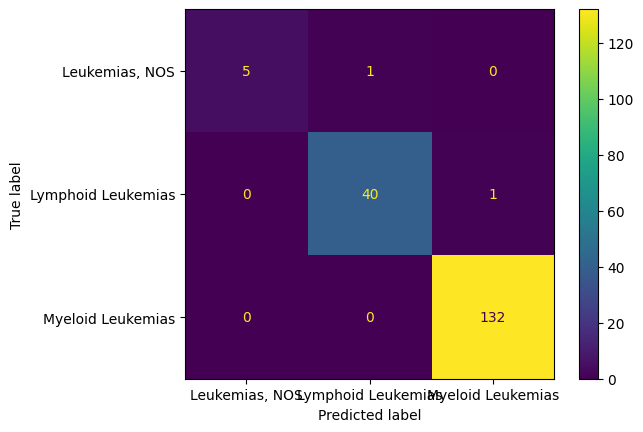

In [22]:
import numpy as np
pred = model1.predict(X_test)
val = y_test

# reverse the mapping of our target variable back into the names of the Leukemia types
reverse_mapping = {0:"Myeloid Leukemias", 1:"Lymphoid Leukemias", 2:"Leukemias, NOS"}

val = np.array([reverse_mapping[i] for i in val])

pred = np.array([reverse_mapping[i] for i in pred])

# Create a confusion matrix of our results
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm1 = ConfusionMatrixDisplay.from_predictions(val, pred)


This model preforms very well as it only makes 2 wrong predictions out of 180 samples

## Variable Importance


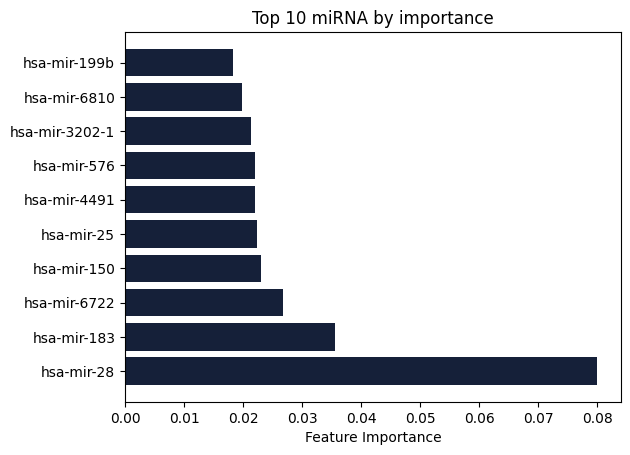

In [25]:
import pandas as pd
top10_important = pd.DataFrame({"miRNA_id":model1.feature_names_in_, "Importance":model1.feature_importances_}).sort_values("Importance", ascending=False).head(10)
plt.barh(top10_important["miRNA_id"], top10_important["Importance"], color = "#152039")
plt.title("Top 10 miRNA by importance")
plt.xlabel("miRNA ID")
plt.xlabel("Feature Importance")
plt.show()

## Create Model Using Only Top 10 

In [27]:
# remove columns from X that are not in the top most important
X_test_reduced = X_test.loc[:, top10_important["miRNA_id"]]
X_train2_reduced = X_train2.loc[:, top10_important["miRNA_id"]]

In [28]:

# Recreate an AdaBoost classifier using the specified weak learner and parameters

# Fit the AdaBoost classifier to the training data (X_train2_reduced, y_train2).
model2 = AdaBoostClassifier(
    estimator=weak_learner,
    n_estimators=n_estimators,
    algorithm="SAMME",
    random_state=42,
).fit(X_train2_reduced, y_train2)
# Calculate the misclassification error for the new model and display results
m2_misclassification_error = misclassification_error(
    y_test, model2.predict(X_test_reduced)
)

print(
    "Reduced Boosting Model's misclassification_error: "
    f"{m2_misclassification_error:.3f}"
)
print(
    "Boosting Model's misclassification error: "
    f"{boosting_model_misclassification_error:.3f}"
)

Reduced Boosting Model's misclassification_error: 0.022
Boosting Model's misclassification error: 0.011


Our misclassification error increases by 100% as we reduced the number of input variables in our model. In some cases this is problematic bu our case we are going from 2 misclassified observations to 4 misclassified observations. It is also important to note that we are using 10 input variables instead of 1881

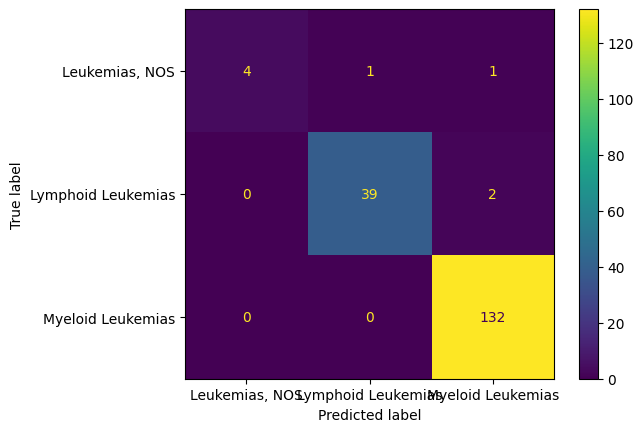

In [34]:
# Reverse the mapping and create a confusion matrix
pred = model2.predict(X_test_reduced)
val = y_test

reverse_mapping = {0:"Myeloid Leukemias", 1:"Lymphoid Leukemias", 2:"Leukemias, NOS"}

val = np.array([reverse_mapping[i] for i in val])

pred = np.array([reverse_mapping[i] for i in pred])

cm2 = ConfusionMatrixDisplay.from_predictions(val, pred)


# Reduced Model on Training and Validation Data

In [35]:
X_val_reduced = X_val.loc[:, top10_important["miRNA_id"]]
X_train_reduced = X_train.loc[:, top10_important["miRNA_id"]]

final_model = model2 = AdaBoostClassifier(
    estimator=weak_learner,
    n_estimators=300,
    algorithm="SAMME",
    random_state=42,
).fit(X_train_reduced, y_train)

Reduced Boosting Model's misclassification_error: 0.022


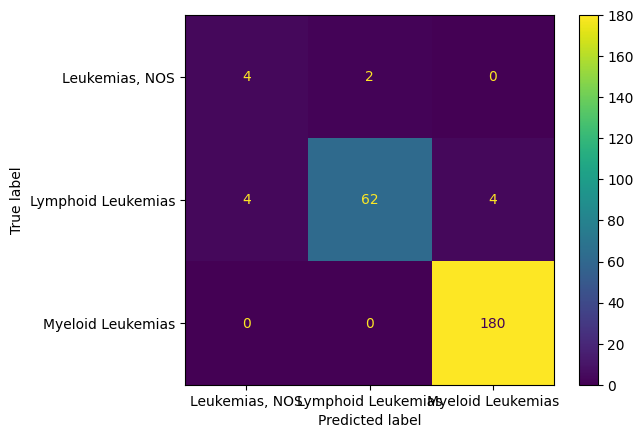

In [37]:
final_me = misclassification_error(
    y_val, model2.predict(X_val_reduced)
)

print(
    "Reduced Boosting Model's misclassification_error: "
    f"{m2_misclassification_error:.3f}"
)
pred = final_model.predict(X_val_reduced)
val = y_val

reverse_mapping = {0:"Myeloid Leukemias", 1:"Lymphoid Leukemias", 2:"Leukemias, NOS"}

val = np.array([reverse_mapping[i] for i in val])

pred = np.array([reverse_mapping[i] for i in pred])

cm2 = ConfusionMatrixDisplay.from_predictions(val, pred)

## Illustrate Majority Vote

In [40]:
input_prediction = X_val_reduced.iloc[50]

vote = {}
for i in range(3):
    vote[i] = 0
for i in final_model.staged_predict(np.array([input_prediction])):
    vote[i[0]] += 1

vote

c:\Users\gmandl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\Users\gmandl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


{0: 0, 1: 300, 2: 0}

What I have done is created a dictionairy where the keys are represented by the classes of the target variable and the values are the number of the weak classiifiers which voted for the class

In [43]:
def create_vote(model, X):
    """
    Create a dictionary representing the votes from different weak learners in an ensemble model.

    Parameters:
    - model: The ensemble model with staged predictions.
    - X: Input data point for which votes are calculated.

    Returns:
    - dict: A dictionary where keys are class indices and values are the normalized votes for each class.
    """
    import numpy as np

    # Initialize a dictionary to store votes for each class
    vote = {}

    # Initialize vote counts for each class to 0
    for i in range(model.n_classes_):
        vote[i] = 0

    # Iterate over the staged predictions of the model for the input data point
    for i in model.staged_predict(np.array([X])):
        # Increment the vote count for the predicted class
        vote[i[0]] += 1

    # Normalize the votes by dividing by the total number of weak learners
    for i in range(model.n_classes_):
        vote[i] = vote[i] / len(model1.estimator_errors_)

    return vote

In [46]:
vote = create_vote(final_model, input_prediction)

c:\Users\gmandl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\Users\gmandl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


In [47]:
def cross_entropy(vote):
    """
    Calculate the cross-entropy from a dictionary of class probabilities.

    Parameters:
    - vote: A dictionary where keys are class indices, and values are class probabilities.

    Returns:
    - float: The calculated cross-entropy.
    """
    from math import log

    # Initialize the cross-entropy value
    ce = 0

    # Iterate over the keys (class indices) in the dictionary
    for i in vote.keys():
        # Skip classes with zero probability to avoid log(0) issues
        if vote[i] == 0:
            continue

        # Update the cross-entropy using the formula: -p * log(p)
        ce += vote[i] * log(vote[i])

    # Return the negation of the total cross-entropy
    return -ce

confidence = 1 - cross_entropy(vote)
confidence

1.0

I propose cross entropy as a measure of confidence in the predictions of our boosting model. Cross entropy is low when values in a group all belong to the same class. So if all the classifiers in our model vote for the same class then the cross entropy in our vote will be low. If the classifiers do not agree then the cross entropy will rise, maxing out at 0.5. To measure confidence I have subracted the cross entropy from 1 such that values closer to one represent more confidence and confidence falls as the confidence values approaches 0.5.

### Plot vote using Pie Chart

In [50]:
true = df2.loc[
y_val.index, "disease_type"]
input_prediction = X_val_reduced.loc[pred != true].iloc[5]
vote = create_vote(final_model, input_prediction)
vote

c:\Users\gmandl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\Users\gmandl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


{0: 0.9466666666666667, 1: 0.05333333333333334, 2: 0.0}

Text(0.5, 1.0, 'Boosting Vote for Observation. Confidence: 0.79')

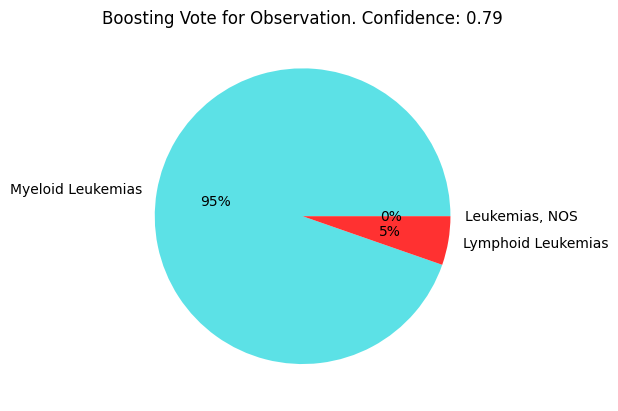

In [52]:
import matplotlib.pyplot as plt

labels = [x[0] for x in vote.items()]
labels = [reverse_mapping[i] for i in labels]
sizes =[x[1] for x in vote.items()]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels,autopct='%.0f%%',
colors=['#5CE1E6', '#FF3131', '#152039'])
plt.title("Boosting Vote for Observation. Confidence: {:.2f}".format(1-cross_entropy(vote)))